In [1]:
import numpy as np
import pandas as pd
import string
import nltk
import itertools
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


from sklearn.ensemble import RandomForestClassifier

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])

In [4]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))

def tokenize(text):

    # Usunięcie wielkich liter
    clean_text = text.lower()

    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))

stopwords = nltk.corpus.stopwords.words("english")

def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))

stemmer = nltk.PorterStemmer()
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))

lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))

In [5]:
words_spam = list(spam_dataset.loc[spam_dataset['Spam']==1, 'Lemmatized_Text'].values)
words_spam = list(itertools.chain.from_iterable(words_spam))
words_spam = ' '.join(words_spam)
words_notspam = list(spam_dataset.loc[spam_dataset['Spam']==0, 'Lemmatized_Text'].values)
words_notspam = list(itertools.chain.from_iterable(words_notspam))
words_notspam = ' '.join(words_notspam)

In [6]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

# ZAMIANA TEKSTU W WEKTOR (TF-IDF)

In [7]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), max_df=0.5, min_df=0.001, use_idf=True)
X = spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x))
y = spam_dataset['Spam']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [8]:
model_pipeline = Pipeline(steps=[('preprocessor', TfidfVectorizer(ngram_range=(2, 2), max_df=0.5, min_df=0.001, use_idf=True)),
                                 ('model', RandomForestClassifier(n_estimators=1000, n_jobs=-1))])

X_test_forest = tfidf.fit_transform(X_test)
X_train_forest = tfidf.fit_transform(X_train)

forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
forest = forest.fit(X_train_forest, y_train)

In [9]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.096 seconds


C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 142 (\x8e) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 139 (\x8b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


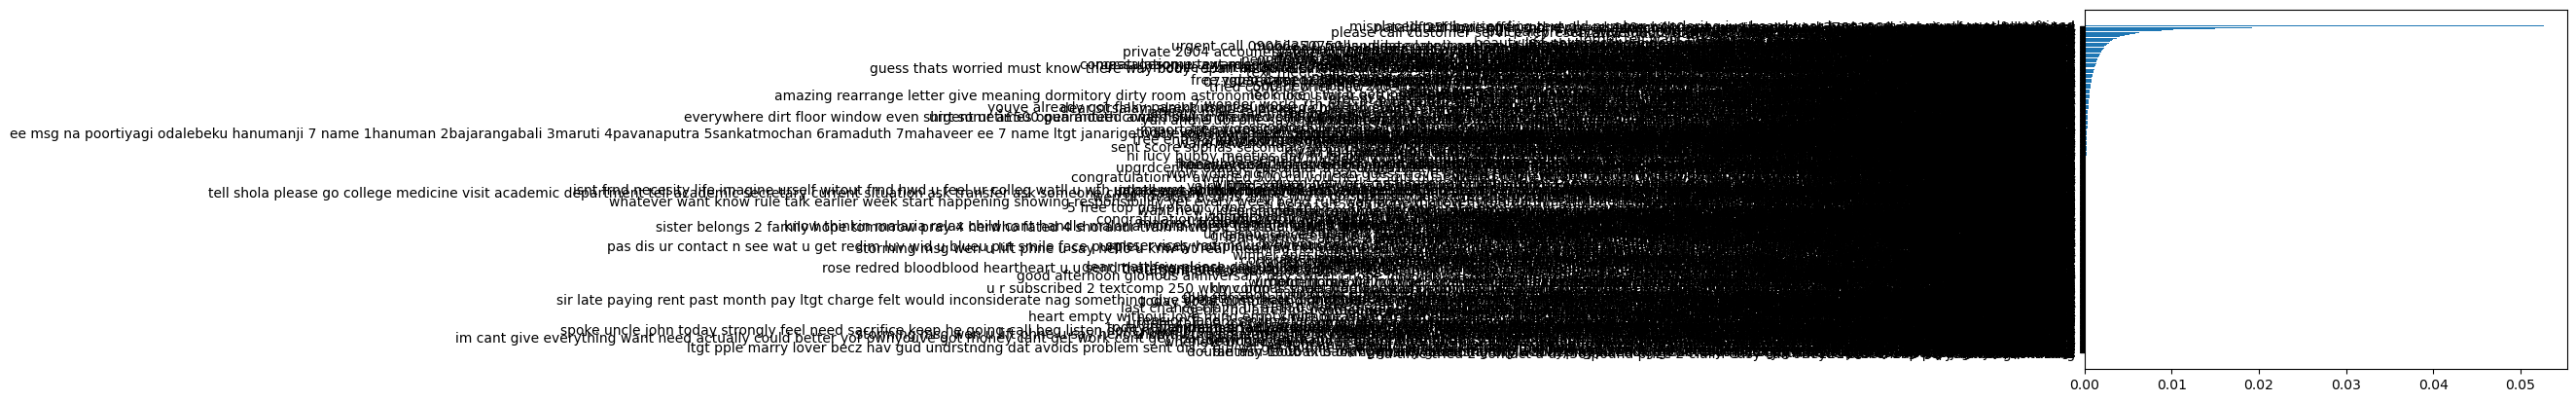

In [10]:
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train)[indices])

In [21]:
X_imp = X_train.copy()
y_imp = y_train.copy()

In [22]:
X_imp.reset_index(drop=True, inplace=True)
y_imp.reset_index(drop=True, inplace=True)

In [23]:
j = 0
for i in importances:
    if i < 0.001:
        X_imp.drop(labels = j, inplace=True)
        y_imp.drop(labels = j, inplace=True)
    j+=1

In [24]:
X_imp.size

3085

In [25]:
y_imp.size

3085

In [26]:
params = {'model__max_depth': [3, 5, 10, 20],
          'model__min_samples_leaf': [3, 5, 10, 15],
          'preprocessor__min_df': [0.01, 0.001],
          'preprocessor__ngram_range': [(1, 1), (2, 2)]}

grid_search = GridSearchCV(model_pipeline, params, cv=5, n_jobs=-1, verbose=10, scoring='f1_macro')

grid_search.fit(X_imp, y_imp)

print('Wybrane hiperparametry: ', grid_search.best_params_)
model_pipeline_v1 = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Wybrane hiperparametry:  {'model__max_depth': 20, 'model__min_samples_leaf': 3, 'preprocessor__min_df': 0.01, 'preprocessor__ngram_range': (1, 1)}


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1206
           1       0.96      0.75      0.84       187

    accuracy                           0.96      1393
   macro avg       0.96      0.87      0.91      1393
weighted avg       0.96      0.96      0.96      1393



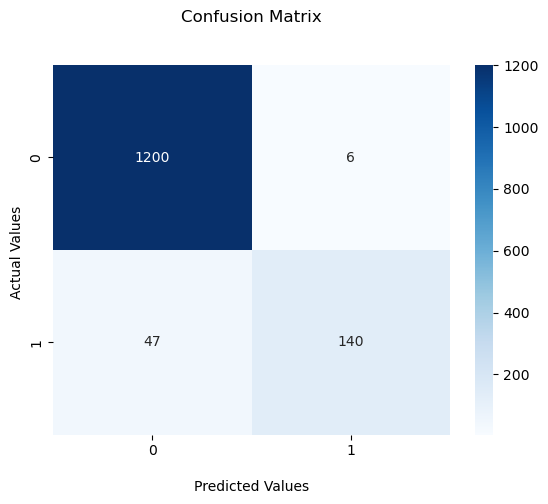

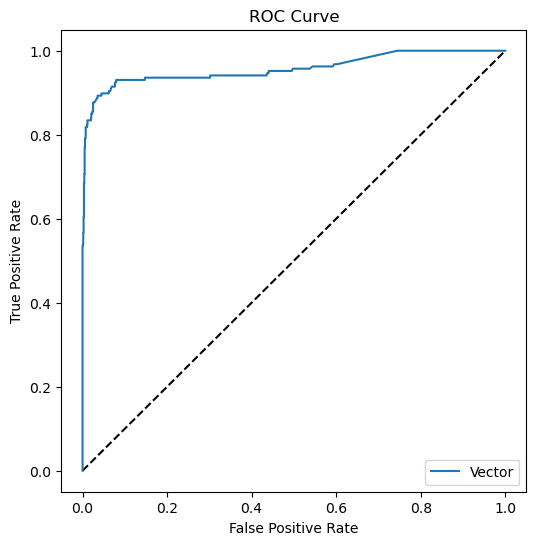

C:\Users\Admin\AppData\Local\Temp\ipykernel_15220\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Vector,0.840841,0.95723


In [27]:
calculate_metrics(model_pipeline_v1, 'Vector', X_test, y_test)

In [28]:
model_pipeline_v2 = Pipeline(steps=[('preprocessor', CountVectorizer(min_df=0.001, max_df=0.5)),
                                 ('model', RandomForestClassifier(n_estimators=1000, n_jobs=-1))])

In [29]:
params = {'model__max_depth': [3, 5, 10, 20],
          'model__min_samples_leaf': [3, 5, 10, 15],
          'preprocessor__min_df': [0.01, 0.001],
          'preprocessor__ngram_range': [(1, 1), (2, 2)]}

grid_search = GridSearchCV(model_pipeline_v2, params, cv=5, n_jobs=-1, verbose=10, scoring='f1_macro')

grid_search.fit(X_train, y_train)

print('Wybrane hiperparametry: ', grid_search.best_params_)
model_pipeline_v2 = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Wybrane hiperparametry:  {'model__max_depth': 20, 'model__min_samples_leaf': 3, 'preprocessor__min_df': 0.001, 'preprocessor__ngram_range': (1, 1)}


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1206
           1       0.99      0.66      0.79       187

    accuracy                           0.95      1393
   macro avg       0.97      0.83      0.88      1393
weighted avg       0.96      0.95      0.95      1393



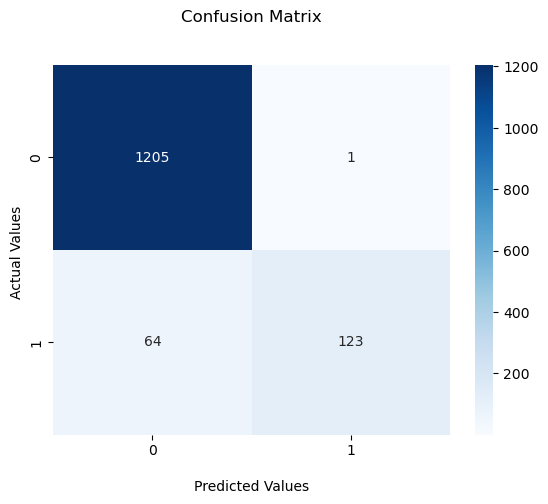

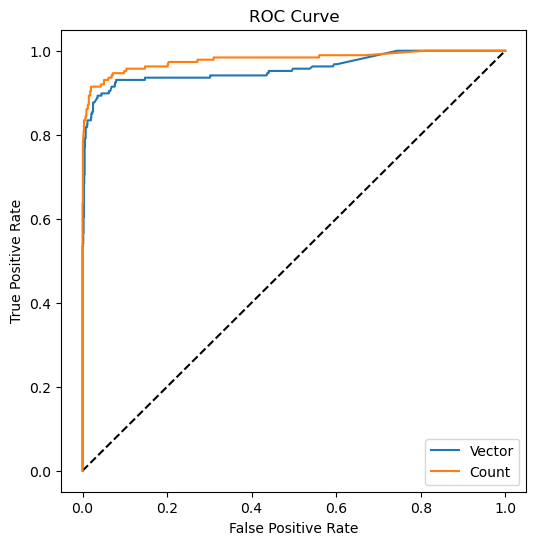

C:\Users\Admin\AppData\Local\Temp\ipykernel_15220\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Vector,0.840841,0.957230
1,Count,0.790997,0.978758


In [30]:
calculate_metrics(model_pipeline_v2, 'Count', X_test, y_test)